<a href="https://colab.research.google.com/github/escuccim/pytorch-face-autoencoder/blob/master/eas7_faces_gan_simple_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After trying to train the GAN and the Autoencoder at the same time and having no luck I decided to try to train the GAN from scratch the make sure it was working. Now that I finally have it working, I think it might make more sense to train the GAN first - with only the Decoder and the Discriminator - and then attempt to add the Encoder once that is working. This might work better since then the Encoder would be trying to format the noise to make it generate the desired output.

In [0]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt, colors
%matplotlib inline
import zipfile
import os
import matplotlib.animation as animation
import torchvision.utils as vutils
import numpy as np

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

In [0]:
# # !gsutil cp gs://{bucket_name}/model_30_trained.pt ./gen_model_1g.pt
# # !gsutil cp gs://{bucket_name}/model_1g.pt ./model_1g.pt
# # !gsutil cp gs://{bucket_name}/model_1d.pt ./model_1d.pt

# # !gsutil cp gs://{bucket_name}/gen_model_31.pt ./gen_model_1g.pt
# # !gsutil cp gs://{bucket_name}/disc_model_31.pt ./disc_model_1g.pt

In [0]:
# if not os.path.exists("celeb_a_good.zip"):
# #   !kaggle datasets download -d jessicali9530/celeba-dataset
#   !gsutil cp gs://{bucket_name}/celeb_a_good.zip ./celeb_a_good.zip
#   zip_ref = zipfile.ZipFile('celeb_a_good.zip', 'r')
#   zip_ref.extractall('data/images/celeb_a')
#   zip_ref.close()

# if not os.path.exists("Training_Pictures.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
#   zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
#   zip_ref.extractall('data/images/training')
#   zip_ref.close()
  
# if not os.path.exists("imdb_crop_good.zip"):  
#   !gsutil cp gs://{bucket_name}/imdb_crop_good.zip ./imdb_crop_good.zip
#   zip_ref = zipfile.ZipFile('imdb_crop_good.zip', 'r')
#   zip_ref.extractall('data/images/imdb')
#   zip_ref.close()

# if not os.path.exists("crop_part1_good.zip"):
#   !gsutil cp gs://{bucket_name}/crop_part1_good.zip ./crop_part1_good.zip
#   zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
#   zip_ref.extractall('data/images/crop_parta')
#   zip_ref.close()   

In [0]:
# # get test data
# if not os.path.exists("imdb_crop_test.zip"):
#   !gsutil cp gs://{bucket_name}/imdb_crop_test.zip ./imdb_crop_test.zip
#   zip_ref = zipfile.ZipFile('imdb_crop_test.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()
  
# # if not os.path.exists("wiki_images_good.zip"):
# #   !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./wiki_images_good.zip
# #   zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
# #   zip_ref.extractall('data/test_images')
# #   zip_ref.close()  

# # if not os.path.exists("faces94.zip"):
# #   !wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
# #   zip_ref = zipfile.ZipFile('faces94.zip', 'r')
# #   zip_ref.extractall('data/test_images')
# #   zip_ref.close()
  
# # # if not os.path.exists("faces96.zip"):
# # #   !wget https://cswww.essex.ac.uk/mv/allfaces/faces96.zip  
# # #   zip_ref = zipfile.ZipFile('faces96.zip', 'r')
# # #   zip_ref.extractall('data/test_images')
# # #   zip_ref.close()

# # if not os.path.exists("faces95.zip"):
# #   !wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip  
# #   zip_ref = zipfile.ZipFile('faces95.zip', 'r')
# #   zip_ref.extractall('data/test_images')
# #   zip_ref.close()

# # # if not os.path.exists("GWB_200x200_JPEG.zip"):
# # #   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
# # #   zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
# # #   zip_ref.extractall('data/test_images')
# # #   zip_ref.close()  
  
# # if not os.path.exists("celeb_a_test.zip"):
# #   !gsutil cp gs://{bucket_name}/celeb_a_test.zip ./celeb_a_test.zip
# #   zip_ref = zipfile.ZipFile('celeb_a_test.zip', 'r')
# #   zip_ref.extractall('data/test_images')
# #   zip_ref.close()       
  
# # if not os.path.exists("wiki_crop_test.zip"):
# #   !gsutil cp gs://{bucket_name}/wiki_crop_test.zip ./wiki_crop_test.zip
# #   zip_ref = zipfile.ZipFile('wiki_crop_test.zip', 'r')
# #   zip_ref.extractall('data/test_images')
# #   zip_ref.close()     
  

# # if not os.path.exists("crop_part1_test.zip"):
# #   !gsutil cp gs://{bucket_name}/crop_part1_test.zip ./crop_part1_test.zip
# #   zip_ref = zipfile.ZipFile('crop_part1_test.zip', 'r')
# #   zip_ref.extractall('data/test_images')
# #   zip_ref.close()     

In [0]:
# Root directory for dataset
dataroot = "data/images"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 48

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = (192,160)

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 512

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [0]:
BATCH_SIZE = batch_size
data_path = "data/images"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=5, translate=(0.075,0.075), scale=(0.9,1.15), shear=4, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.RandomResizedCrop(image_size, scale=(0.8, 1.20)),
      torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.05)),
      torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=3,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    num_workers=3,
    shuffle=True
)

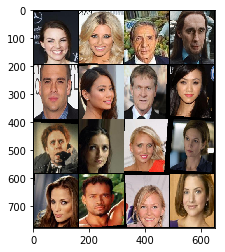

In [0]:
real_batch = next(iter(train_loader))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, nrow=4, normalize=True).cpu(),(1,2,0)))
plt.show()

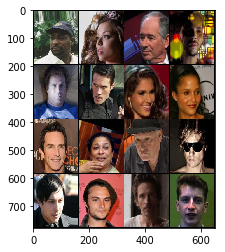

In [0]:
real_batch = next(iter(test_loader))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [0]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 259336
    Root Location: data/images
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.5)
                             RandomApply(
                             p=0.7
                             RandomAffine(degrees=(-5, 5), translate=(0.075, 0.075), scale=(0.9, 1.15), shear=(-4, 4))
                         )
                             RandomResizedCrop(size=(192, 160), scale=(0.8, 1.2), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [0]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 49480
    Root Location: data/test_images
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(192, 160), scale=(0.95, 1.05), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [0]:
def output_size(i, k=3, p=2, s=1, d=1):
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    return o
  
output_size(i=64, k=3, p=1)

64.0

### Create Models

In [0]:
epoch_list = []
img_list = []

In [0]:
criterion = torch.nn.BCELoss()
mse_loss = nn.MSELoss()
real_label = 0.10
fake_label = 1.0

# real_label = 0.99
# fake_label = 0.10

latent_dim = 512

fixed_noise = torch.randn(16, latent_dim, 1, 1).cuda()
criterion = torch.nn.BCELoss()

def vae_loss(x, x_hat, mu=None, logvar=None, d_faked=None, labels=None, debug=False):
    beta_mse = 10.0
    beta_kld = 1.0
    beta_gloss = 1.0
    
    # MSE for reconstructions
    MSE = mse_loss(x_hat, x)
    MSE *= beta_mse
    
    if d_faked is not None and labels is not None:
        g_loss = criterion(d_faked, labels)
        g_loss *= beta_gloss
    
    if mu is not None and logvar is not None:
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) 
        KLD *= beta_kld
    else:
        KLD = torch.zeros(1)
    
    # print out loss info if we want to debug
    if debug:
        print("MSE Loss Raw:", MSE)
        print("MSE Loss Weighted:", MSE * beta_mse)
        print("KLD Loss Raw:", KLD)
        print("KLD Loss Weighted:", KLD * beta_kld)
        if d_faked is not None:
            print("Disc Loss Raw:", g_loss)
            print("Disc Loss Weighted:", g_loss * beta_gloss)
        print("Total Loss (weighted):", MSE + g_loss + KLD)
    
    return MSE + g_loss + KLD, MSE, KLD, g_loss
  
def disc_loss(labels, logits):
    s_logits = torch.sigmoid(logits)    
    d_loss = criterion(s_logits, labels)
    return d_loss

def disc_loss2(labels, logits):
    d_loss = nn.functional.binary_cross_entropy_with_logits(logits, labels, reduction="mean")
    
    return d_loss    

# Training Loop
def train_gan_2(netD, netG, optimizerD, optimizerG, train_loader=train_loader, test_loader=None, num_epochs=5):
    try:
        print("Starting Training Loop...")
        # For each epoch
        for epoch in range(num_epochs):
            # Lists to keep track of progress
            G_losses = []
            D_losses = []
            iters = 0
            
            MSE_losses = []
            XE_losses = []
            KLD_losses = []
            
            netD.train()
            netG.train()
            
            # For each batch in the dataloader
            for i, data in enumerate(train_loader, 0):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                netD.zero_grad()
                # Format batch
                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, device=device)
                # Forward pass real batch through D
                output = netD(real_cpu).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label + 0.1)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                
                # Generate fake image batch with G
                fake, code, logvar = netG(real_cpu)
                
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = netD(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                try:
                    errD_fake = criterion(output, label)
                    # Calculate the gradients for this batch
                    errD_fake.backward()
                    D_G_z1 = output.mean().item()
                    # Add the gradients from the all-real and all-fake batches
                    errD = errD_real + errD_fake
                    # Update D
                    optimizerD.step()
                except:
                    print("Error with loss Output - Min:", output.detach().cpu().min(), "Max:", output.detach().cpu().max())
                    print("Error with loss Labels - Min:", label.detach().cpu().min(), "Max:", label.detach().cpu().max())
                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                netG.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = netD(fake).view(-1)
                
                # Calculate G's loss based on this output
#                 errG = criterion(output, label)
                errG, MSE_loss, KLD_loss, g_loss = vae_loss(real_cpu, fake, mu=code, logvar=logvar, d_faked=output, labels=label)
                
                MSE_losses.append(MSE_loss.item())
                XE_losses.append(g_loss.item())
                KLD_losses.append(KLD_loss.item())
                D_G_z2 = output.mean().item()
            
                # Calculate gradients for G
                errG.backward()
                
                # Update G
                optimizerG.step()

                # Output training stats
                if i % 100 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tXE Loss: %.4f\tKLD Loss: %.4f\tMSE Loss: %.4f'
                          % (epoch, num_epochs, i, len(train_loader),
                             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, np.mean(XE_losses), np.mean(KLD_losses), np.mean(MSE_losses)))
                if i % 500 == 0 and i > 0:
                  with torch.no_grad():
                      fake, _, _ = netG(real_cpu)
                      fake = fake.detach().cpu()
                      fig, ax = plt.subplots(1, 2, figsize=(8,8))
                      ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:4], nrow=2, padding=2, normalize=True),(1,2,0)))
                      ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:4], nrow=2, padding=2, normalize=True),(1,2,0)))
                      plt.show()  

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 2000 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        fake, _, _ = netG(real_cpu)
                        fake = fake.detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1

            torch.save(netG.state_dict(), g_save_path)
            torch.save(netD.state_dict(), d_save_path)

            # plot some images
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()    
            
            # run on test dataset
            if False: #test_loader is not None:
                netD.eval()
                netG.eval()
                
                r_outputs = []
                f_outputs = []
                g_losses = []
                d_losses = []
                
                with torch.no_grad():
                    for (inputs, _) in test_loader:
                        # copy the data to GPU
                        inputs.cuda()
                        
                        # run the data through the network
                        fake, code, logvar = netG(inputs)
                        r_output = netD(inputs)
                        r_outputs.append(r_output)
                        
                        f_output = netD(fake)
                        f_outputs.append(f_output)
                        
                        # run the loss functions
                        label = torch.full((b_size,), real_label, device=device)
                        d_loss_real = criterion(r_output, label)
                        d_losses.append(d_loss_real.item())
                        
                        label.fill_(fake_label)
                        d_loss_fake = criterion(f_output, label)
                        d_losses.append(d_loss_fake.item())
                        
                        # run the generator loss function
                        label.fill_(real_label)
                        errG, MSE_loss, KLD_loss, g_loss = vae_loss(inputs, fake, mu=code, logvar=logvar, d_faked=f_output, labels=label)
                        g_losses.append(errG.item())
                        
                # print out some images
                fig, ax = plt.subplots(1, 2, figsize=(8,8))
                ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
                ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
                plt.show()    
            else:
                r_outputs = [0]
                f_outputs = [0]
                g_losses = [0]
                d_losses = [0]
                
            # print some metrics
            print("Epoch", epoch, "G Loss:", np.mean(G_losses), "D Loss:", np.mean(D_losses), "Test G Loss:", np.mean(g_losses), "Test D Loss:", np.mean(d_losses), "Test Real D:", np.mean(r_outputs), "Test Fake D:", np.mean(f_outputs))
            
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()    
            
    except KeyboardInterrupt:
        print("Interrupt")
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)
    except Exception as e:        
        print("Error", e)
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)
    
#     !gsutil cp {g_save_path} gs://{bucket_name}/{g_save_path}
#     !gsutil cp {d_save_path} gs://{bucket_name}/{d_save_path}
  
    
# Training Loop
def train_gan_3(netD, netG, optimizerD, optimizerG, train_loader=train_loader, test_loader=None, num_epochs=5):
    try:
        print("Starting Training Loop...")
        # For each epoch
        for epoch in range(num_epochs):
            # Lists to keep track of progress
            G_losses = []
            D_losses = []
            iters = 0
            
            MSE_losses = []
            XE_losses = []
            KLD_losses = []
            
            netD.train()
            netG.train()
            
            # For each batch in the dataloader
            for i, data in enumerate(train_loader, 0):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                netD.zero_grad()
                # Format batch
                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, device=device)
                # Forward pass real batch through D
                output = netD(real_cpu).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label + 0.1)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                
                # Generate fake image batch with G
                fake, code, logvar = netG(real_cpu)
                
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = netD(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                try:
                    errD_fake = criterion(output, label)
                    # Calculate the gradients for this batch
                    errD_fake.backward()
                    D_G_z1 = output.mean().item()
                    # Add the gradients from the all-real and all-fake batches
                    errD = errD_real + errD_fake
                    # Update D
                    optimizerD.step()
                except:
                    print("Error with loss Output - Min:", output.detach().cpu().min(), "Max:", output.detach().cpu().max())
                    print("Error with loss Labels - Min:", label.detach().cpu().min(), "Max:", label.detach().cpu().max())
                
                ###########################
                # Another update for just the decoder
                ###########################
                netG.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                fake_2 = netG.decoder(noise)
                
                # run through D
                output = netD(fake_2).view(-1)
                
                errG_2 = criterion(output, label)
                # Calculate gradients for G
                errG_2.backward()
                # Update G
#                 optimizerG.step()
                
                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                netG.zero_grad()
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = netD(fake).view(-1)
                
                # Calculate G's loss based on this output
                errG, MSE_loss, KLD_loss, g_loss = vae_loss(real_cpu, fake, mu=code, logvar=logvar, d_faked=output, labels=label)
                
                MSE_losses.append(MSE_loss.item())
                XE_losses.append(g_loss.item())
                if KLD_loss.item() < 100:
                    KLD_losses.append(KLD_loss.item())
                else:
                    KLD_losses.append(100)
                    
                D_G_z2 = output.mean().item()
            
                # Calculate gradients for G
                errG.backward()
                errG = errG_2 + errG
                
                # Update G
                optimizerG.step()
                
                # Output training stats
                if i % 100 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tXE Loss: %.4f\tKLD Loss: %.4f\tMSE Loss: %.4f'
                          % (epoch, num_epochs, i, len(train_loader),
                             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, np.mean(XE_losses), np.mean(KLD_losses), np.mean(MSE_losses)))
                if i % 250 == 0 and i > 0:
                  with torch.no_grad():
                      fake, _, _ = netG(real_cpu)
                      fake = fake.detach().cpu()
                      fig, ax = plt.subplots(1, 2, figsize=(8,8))
                      ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:4], nrow=2, padding=2, normalize=True),(1,2,0)))
                      ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:4], nrow=2, padding=2, normalize=True),(1,2,0)))
                      plt.show()  

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 2000 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        fake, _, _ = netG(real_cpu)
                        fake = fake.detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1

            torch.save(netG.state_dict(), g_save_path)
            torch.save(netD.state_dict(), d_save_path)

            # plot some images
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()    
            
            # run on test dataset
            if False: #test_loader is not None:
                netD.eval()
                netG.eval()
                
                r_outputs = []
                f_outputs = []
                g_losses = []
                d_losses = []
                
                with torch.no_grad():
                    for (inputs, _) in test_loader:
                        # copy the data to GPU
                        inputs.cuda()
                        
                        # run the data through the network
                        fake, code, logvar = netG(inputs)
                        r_output = netD(inputs)
                        r_outputs.append(r_output)
                        
                        f_output = netD(fake)
                        f_outputs.append(f_output)
                        
                        # run the loss functions
                        label = torch.full((b_size,), real_label, device=device)
                        d_loss_real = criterion(r_output, label)
                        d_losses.append(d_loss_real.item())
                        
                        label.fill_(fake_label)
                        d_loss_fake = criterion(f_output, label)
                        d_losses.append(d_loss_fake.item())
                        
                        # run the generator loss function
                        label.fill_(real_label)
                        errG, MSE_loss, KLD_loss, g_loss = vae_loss(inputs, fake, mu=code, logvar=logvar, d_faked=f_output, labels=label)
                        g_losses.append(errG.item())
                        
                # print out some images
                fig, ax = plt.subplots(1, 2, figsize=(8,8))
                ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
                ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
                plt.show()    
            else:
                r_outputs = [0]
                f_outputs = [0]
                g_losses = [0]
                d_losses = [0]
                
            # print some metrics
            print("Epoch", epoch, "G Loss:", np.mean(G_losses), "D Loss:", np.mean(D_losses), "Test G Loss:", np.mean(g_losses), "Test D Loss:", np.mean(d_losses), "Test Real D:", np.mean(r_outputs), "Test Fake D:", np.mean(f_outputs))
            
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()    
            
    except KeyboardInterrupt:
        print("Interrupt")
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)
    except Exception as e:        
        print("Error", e)
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)
    

# Training Loop
def train_gan_4(netD, netG, optimizerD, optimizerG, optimizerDecoder, train_loader=train_loader, test_loader=None, num_epochs=5):
    try:
        print("Starting Training Loop...")
        # For each epoch
        for epoch in range(num_epochs):
            # Lists to keep track of progress
            G_losses = []
            D_losses = []
            iters = 0
            
            MSE_losses = []
            XE_losses = []
            KLD_losses = []
            
            netD.train()
            netG.train()
            
            # For each batch in the dataloader
            for i, data in enumerate(train_loader, 0):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                netD.zero_grad()
                # Format batch
                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, device=device)
                # Forward pass real batch through D
                output = netD(real_cpu).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label + 0.1)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                
                # Generate fake image batch with G
                fake, code, logvar = netG(real_cpu)
                
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = netD(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                try:
                    errD_fake = criterion(output, label)
                    # Calculate the gradients for this batch
                    errD_fake.backward()
                    D_G_z1 = output.mean().item()
                    # Add the gradients from the all-real and all-fake batches
                    errD = errD_real + errD_fake
                    # Update D
                    optimizerD.step()
                except:
                    print("Error with loss Output - Min:", output.detach().cpu().min(), "Max:", output.detach().cpu().max())
                    print("Error with loss Labels - Min:", label.detach().cpu().min(), "Max:", label.detach().cpu().max())
                
                ###########################
                # Train the decoder on noise
                ###########################
                netG.decoder.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                fake_2 = netG.decoder(noise)
                
                # run through D
                output = netD(fake_2).view(-1)
                
                errG_2 = criterion(output, label)
                # Calculate gradients for G
                errG_2.backward()
                optimizerDecoder.step()
                
                ############################
                # Train the encoder on the inputs
                ###########################
                netG.zero_grad()
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = netD(fake).view(-1)
                
                # Calculate G's loss based on this output
                errG, MSE_loss, KLD_loss, g_loss = vae_loss(real_cpu, fake, mu=code, logvar=logvar, d_faked=output, labels=label)
                
                MSE_losses.append(MSE_loss.item())
                XE_losses.append(g_loss.item())
                if KLD_loss.item() < 100:
                    KLD_losses.append(KLD_loss.item())
                else:
                    KLD_losses.append(100)
                    
                D_G_z2 = output.mean().item()
                
                # Calculate gradients for G
                errG.backward()
                
                # add the errors
                errG_total = errG + errG_2
                
                # Update G
                optimizerG.step()
                
                # Output training stats
                if i % 100 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tXE Loss: %.4f\tKLD Loss: %.4f\tMSE Loss: %.4f'
                          % (epoch, num_epochs, i, len(train_loader),
                             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, np.mean(XE_losses), np.mean(KLD_losses), np.mean(MSE_losses)))
                if i % 500 == 0 and i > 0:
                  with torch.no_grad():
                      fake, _, _ = netG(real_cpu)
                      fake = fake.detach().cpu()
                      fig, ax = plt.subplots(1, 2, figsize=(8,8))
                      ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:4], nrow=2, padding=2, normalize=True),(1,2,0)))
                      ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:4], nrow=2, padding=2, normalize=True),(1,2,0)))
                      plt.show()  

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 2000 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        fake, _, _ = netG(real_cpu)
                        fake = fake.detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1

            torch.save(netG.state_dict(), g_save_path)
            torch.save(netD.state_dict(), d_save_path)

            # plot some images
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()    
            
            # run on test dataset
            if False: #test_loader is not None:
                netD.eval()
                netG.eval()
                
                r_outputs = []
                f_outputs = []
                g_losses = []
                d_losses = []
                
                with torch.no_grad():
                    for (inputs, _) in test_loader:
                        # copy the data to GPU
                        inputs.cuda()
                        
                        # run the data through the network
                        fake, code, logvar = netG(inputs)
                        r_output = netD(inputs)
                        r_outputs.append(r_output)
                        
                        f_output = netD(fake)
                        f_outputs.append(f_output)
                        
                        # run the loss functions
                        label = torch.full((b_size,), real_label, device=device)
                        d_loss_real = criterion(r_output, label)
                        d_losses.append(d_loss_real.item())
                        
                        label.fill_(fake_label)
                        d_loss_fake = criterion(f_output, label)
                        d_losses.append(d_loss_fake.item())
                        
                        # run the generator loss function
                        label.fill_(real_label)
                        errG, MSE_loss, KLD_loss, g_loss = vae_loss(inputs, fake, mu=code, logvar=logvar, d_faked=f_output, labels=label)
                        g_losses.append(errG.item())
                        
                # print out some images
                fig, ax = plt.subplots(1, 2, figsize=(8,8))
                ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
                ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
                plt.show()    
            else:
                r_outputs = [0]
                f_outputs = [0]
                g_losses = [0]
                d_losses = [0]
                
            # print some metrics
            print("Epoch", epoch, "G Loss:", np.mean(G_losses), "D Loss:", np.mean(D_losses), "Test G Loss:", np.mean(g_losses), "Test D Loss:", np.mean(d_losses), "Test Real D:", np.mean(r_outputs), "Test Fake D:", np.mean(f_outputs))
            
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            ax[0].imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(real_cpu.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()    
            
    except KeyboardInterrupt:
        print("Interrupt")
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)
    except Exception as e:        
        print("Error", e)
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)
        
        
def train(model, train_loader, optimizer, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, scheduler=None, save_path="model_6.pt"):
    try:
      for epoch in range(num_epochs):
          model.train()
          upload_path = save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          tr_losses = []
          test_losses = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              optimizer.zero_grad()

              recon, code, logvar = model(inputs)
              if model.variational:
                  loss, _, _, _ = vae_loss(inputs, recon)
              else:  
                  loss, _, _, _ = vae_loss(inputs, recon)

              loss.backward()
              optimizer.step()

              tr_losses.append(loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "loss:", np.mean(tr_losses[-print_metrics:]))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(recon[1].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(model.state_dict(), save_path)
#               !gsutil cp ./model.pt gs://{bucket_name}/
          
          if test_loader is not None:
            model.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                recon, code, logvar = model(inputs)

                if model.variational:
                    loss, _, _, _ = vae_loss(inputs, recon)
                else:  
                    loss, _, _, _ = vae_loss(inputs, recon)

                test_losses.append(loss.item())

            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Train Loss:", np.mean(tr_losses), "Test Loss:", np.mean(test_losses))
          
          epoch_list.append(epoch)
          
          if scheduler is not None and epoch % 5 == 0 and epoch > 1:
              scheduler.step()

                
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    except Exception as e:
      print("Error... Saving model...", e)
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    
    !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      
def count_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params               

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=nz, variational=True):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        self.variational = variational
        
        self.relu = nn.ReLU()
         
        # first layer 3x3 conv, stride 1 - 192x160
        self.conv1 = nn.Conv2d(nc, ndf, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ndf) 
        
        # 3x3 conv, stride 1 - 192x160
        self.conv101 = nn.Conv2d(ndf, ndf, 3, 1, 1, bias=False)
        self.bn101 = nn.BatchNorm2d(ndf) 
        
        # 3x3, stride 1 - 96x80
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
       
        # 3x3, stride 1 - 96x80
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 2)
        
        # 4x4, stride 2 - 48x40
        self.conv4 = nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 4)
        
        # 3x3, stride 1 - 48x40
        self.conv5 = nn.Conv2d(ndf * 4,  ndf * 4, 3, 1, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 4)
        
        # 4x4, stride 2 - 24x20
        self.conv6 = nn.Conv2d(ndf * 4,  ndf * 6, 3, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(ndf * 6)
        
        # 3x3, stride 1 - 24x20
        self.conv7 = nn.Conv2d(ndf * 6,  ndf * 6, 3, 1, 1, bias=False)
        self.bn7 = nn.BatchNorm2d(ndf * 6)
        
        # 4x4, stride 2 - 12x10
        self.conv8 = nn.Conv2d(ndf * 6,  ndf * 12, 3, 2, 1, bias=False)
        self.bn8 = nn.BatchNorm2d(ndf * 12)
        
        # 4x4, stride 2 - 6x5
        self.conv9 = nn.Conv2d(ndf * 12,  ndf * 16, 3, 2, 1, bias=False)
        self.bn9 = nn.BatchNorm2d(ndf * 16)
        
        # 4x4, stride 1
        self.conv10 = nn.Conv2d(ndf * 16, ndf * 8, (6,5), 1, bias=False)
        self.bn10 = nn.BatchNorm2d(ndf * 8)
        
        # 4x4, stride 1 - code
        self.conv11 = nn.Conv2d(ndf * 8, latent_dim, 1, 1, bias=False)
        # 4x4, stride 1 - logvar
        self.conv12 = nn.Conv2d(ndf * 8, latent_dim, 1, 1, bias=False)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_):
      #         print("input:", input_.shape)
        c1 = self.relu(self.bn1(self.conv1(input_)))
#         print("c1", c1.shape)
        c101 = self.relu(self.bn101(self.conv101(c1))) + c1
#         print("c101", c101.shape)
        c2 = self.relu(self.bn2(self.conv2(c101)))
#         print("c2", c2.shape)  
#         c20 = self.relu(self.bn20(self.conv20(c2)))
        c3 = self.relu(self.bn3(self.conv3(c2))) + c2
#         print("c3", c3.shape)  
        c4 = self.relu(self.bn4(self.conv4(c3)))
#         print("c4", c4.shape)
        c5 = self.relu(self.bn5(self.conv5(c4))) + c4
#         print("c5", c5.shape)
        c6 = self.relu(self.bn6(self.conv6(c5)))
#         print("c6", c6.shape)
        c7 = self.relu(self.bn7(self.conv7(c6))) + c6
#         print("c7", c7.shape)
        c8 = self.relu(self.bn8(self.conv8(c7)))
#         print("c8", c8.shape)
        c9 = self.relu(self.bn9(self.conv9(c8)))
#         print("c9", c9.shape)
        c10 = self.relu(self.bn10(self.conv10(c9)))
#         print("c10", c10.shape)
        code = self.conv11(c10)
#         print("code", code.shape)
        
        if self.variational:
            logvar = self.conv12(c10)
        else:
            logvar = None

        return code, logvar
      
class Decoder(nn.Module):
    def __init__(self, latent_dim=nz):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()
        
        # latent_dim x 1
        self.conv1 = nn.ConvTranspose2d( latent_dim, ngf * 16, (6,5), 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 16)
        
        self.conv2 = nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 8)
        
        self.conv3 = nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        
        self.conv4 = nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ngf)
        
        self.conv6 = nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(ngf)
        
        self.conv7 = nn.ConvTranspose2d( ngf, 3, 3, 1, 1, bias=False)

    def forward(self, input_):
#         print("input:", input_.shape)
        # 6x5
        c1 = self.relu(self.bn1(self.conv1(input_)))
#         print("c1", c1.shape)
        c2 = self.relu(self.bn2(self.conv2(c1)))
#         print("c2", c2.shape)
        c3 = self.relu(self.bn3(self.conv3(c2)))
#         print("c3", c3.shape)
        c4 = self.relu(self.bn4(self.conv4(c3)))
#         print("c4", c4.shape)
        c5 = self.relu(self.bn5(self.conv5(c4)))
#         c5 = self.upsample(c4)
#         print("c5", c5.shape)
        c6 = self.relu(self.bn6(self.conv6(c5)))
        c7 = self.conv7(c6)
#         print("c6", c6.shape)
        return self.tanh(c7)

# a model that uses the Encoder and Decoder
class Generator(nn.Module):
    def __init__(self, encoder, decoder, variational=False):
        super(Generator, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.variational = variational

    def sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def forward(self, X):
        mu, logvar = encoder(X)

        if self.training and logvar is not None:
            z = self.sample(mu, logvar)
        else:
            z = mu
            
        recon = self.decoder(z)
        
        return recon, mu, logvar
        
class Discriminator(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.relu = nn.LeakyReLU(0.2, inplace=True)
         
        # first layer 3x3 conv, stride 1 - 192x160
        self.conv1 = nn.Conv2d(nc, ndf, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ndf) 
        
        # 3x3 conv, stride 1 - 192x160
        self.conv101 = nn.Conv2d(ndf, ndf, 3, 1, 1, bias=False)
        self.bn101 = nn.BatchNorm2d(ndf) 
        
        # 3x3, stride 1 - 96x80
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
       
        # 3x3, stride 1 - 96x80
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 2)
        
        # 4x4, stride 2 - 48x40
        self.conv4 = nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 4)
        
        # 3x3, stride 1 - 48x40
        self.conv5 = nn.Conv2d(ndf * 4,  ndf * 4, 3, 1, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 4)
        
        # 4x4, stride 2 - 24x20
        self.conv6 = nn.Conv2d(ndf * 4,  ndf * 6, 3, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(ndf * 6)
        
        # 3x3, stride 1 - 24x20
        self.conv7 = nn.Conv2d(ndf * 6,  ndf * 6, 3, 1, 1, bias=False)
        self.bn7 = nn.BatchNorm2d(ndf * 6)
        
        # 4x4, stride 2 - 12x10
        self.conv8 = nn.Conv2d(ndf * 6,  ndf * 12, 3, 2, 1, bias=False)
        self.bn8 = nn.BatchNorm2d(ndf * 12)
        
        # 4x4, stride 2 - 6x5
        self.conv9 = nn.Conv2d(ndf * 12,  ndf * 16, 3, 2, 1, bias=False)
        self.bn9 = nn.BatchNorm2d(ndf * 16)
        
        # 4x4, stride 1
        self.conv10 = nn.Conv2d(ndf * 16, 1, (6,5), 1, bias=False)
        
        self.sigmoid = nn.Sigmoid()
        self.gap = nn.AdaptiveMaxPool2d(1)
        
        self.dropout1 = nn.Dropout2d(0.10)
        self.dropout2 = nn.Dropout2d(0.15)
        
    def forward(self, input_):
        c1 = self.relu(self.bn1(self.conv1(input_)))
#         print("c1", c1.shape)
        c101 = self.relu(self.bn101(self.conv101(c1)))
#         print("c101", c101.shape)
        c2 = self.relu(self.bn2(self.conv2(c101)))
#         print("c2", c2.shape)  
        c3 = self.relu(self.bn3(self.conv3(c2)))
#         print("c3", c3.shape)  
        c4 = self.relu(self.bn4(self.conv4(c3)))
#         print("c4", c4.shape)
        c5 = self.relu(self.bn5(self.conv5(c4)))
#         print("c5", c5.shape)
        c6 = self.relu(self.bn6(self.conv6(c5)))
#         print("c6", c6.shape)
        c7 = self.relu(self.bn7(self.conv7(c6)))
#         print("c7", c7.shape)
        c8 = self.dropout1(self.relu(self.bn8(self.conv8(c7))))
#         print("c8", c8.shape)
        c9 = self.dropout2(self.relu(self.bn9(self.conv9(c8))))
#         print("c9", c9.shape)
        c10 = self.conv10(c9)
#         print("c10:", c10.shape)
#         print("c11", c11.shape)

        return self.sigmoid(c10)

In [0]:
from torch import optim
import numpy as np

g_save_path = "model_1g_4t.pt"
d_save_path = "model_1d_4t.pt"

## YOUR CODE HERE ##
encoder = Encoder(latent_dim, variational=True)
decoder = Decoder(latent_dim)

# decoder.load_state_dict(torch.load(g_save_path), strict=False)

netG = Generator(encoder, decoder).cuda()



# netG = Decoder(nz).cuda()
netD = Discriminator(1).cuda()

print("Autoencoder Params:", count_params(netG))
print("Encoder Params:", count_params(netG.encoder))
print("Decoder Params:", count_params(netG.decoder))
print("Discriminator Params:", count_params(netD))

# run on GPU
use_cuda = True

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1).cuda()

# Establish convention for real and fake labels during training
real_label = 0
fake_label = 1

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerDecoder = optim.Adam(netG.decoder.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerEncoder = optim.Adam(netG.encoder.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

try:
    netG.load_state_dict(torch.load(g_save_path), strict=False)
    print("Generator loaded")
except:
    print("Error loading generator")
    netG.apply(weights_init)

try:
    netD.load_state_dict(torch.load(d_save_path), strict=False)
    print("Discriminator loaded")
except:
    print("Error loading discriminator")
    netD.apply(weights_init)

# generator = generator.decoder

Autoencoder Params: 56290432
Encoder Params: 29349312
Decoder Params: 26941120
Discriminator Params: 13126080
Generator loaded
Discriminator loaded


In [0]:
train_gan_3(netD, netG, optimizerD, optimizerG, num_epochs=5)

Starting Training Loop...
[0/5][0/5403]	Loss_D: 1.3805	Loss_G: 4.5377	D(x): 0.5110	D(G(z)): 0.5222 / 0.5232	XE Loss: 0.7504	KLD Loss: 0.0860	MSE Loss: 3.7013
[0/5][100/5403]	Loss_D: 1.2435	Loss_G: 2.8366	D(x): 0.5149	D(G(z)): 0.6039 / 0.6085	XE Loss: 0.8487	KLD Loss: 0.1146	MSE Loss: 2.4864
[0/5][200/5403]	Loss_D: 0.9988	Loss_G: 2.9812	D(x): 0.4498	D(G(z)): 0.6975 / 0.6976	XE Loss: 0.9782	KLD Loss: 0.1390	MSE Loss: 2.0425
[0/5][300/5403]	Loss_D: 1.0209	Loss_G: 3.0697	D(x): 0.4025	D(G(z)): 0.6527 / 0.6765	XE Loss: 1.0546	KLD Loss: 0.1577	MSE Loss: 1.8916
[0/5][400/5403]	Loss_D: 1.1640	Loss_G: 3.1765	D(x): 0.5145	D(G(z)): 0.6709 / 0.7162	XE Loss: 1.0668	KLD Loss: 0.1712	MSE Loss: 1.8100
Interrupt


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback 

Starting Training Loop...
[0/2][0/4053]	Loss_D: 2.2004	Loss_G: 1.7588	D(x): 0.6438	D(G(z)): 0.8974 / 0.5246
[0/2][50/4053]	Loss_D: 1.1593	Loss_G: 2.5503	D(x): 0.1816	D(G(z)): 0.6130 / 0.8542
[0/2][100/4053]	Loss_D: 0.5637	Loss_G: 5.3823	D(x): 0.1702	D(G(z)): 0.9133 / 0.9837


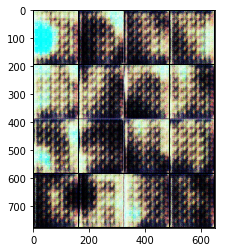

[0/2][150/4053]	Loss_D: 0.8928	Loss_G: 3.9560	D(x): 0.3007	D(G(z)): 0.8284 / 0.9550
[0/2][200/4053]	Loss_D: 0.6621	Loss_G: 7.5001	D(x): 0.1493	D(G(z)): 0.9437 / 0.9969


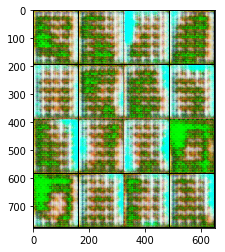

[0/2][250/4053]	Loss_D: 0.7358	Loss_G: 4.4522	D(x): 0.3140	D(G(z)): 0.9711 / 0.9583
[0/2][300/4053]	Loss_D: 0.9479	Loss_G: 5.8282	D(x): 0.0541	D(G(z)): 0.7748 / 0.9938


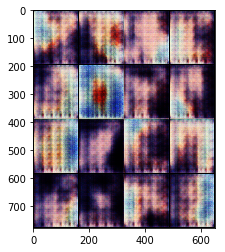

[0/2][350/4053]	Loss_D: 0.9996	Loss_G: 4.5616	D(x): 0.2981	D(G(z)): 0.9254 / 0.9710
[0/2][400/4053]	Loss_D: 1.2253	Loss_G: 3.2540	D(x): 0.5415	D(G(z)): 0.9493 / 0.9127


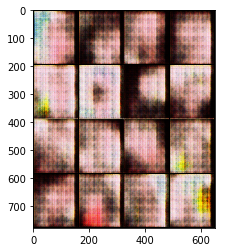

[0/2][450/4053]	Loss_D: 1.0695	Loss_G: 2.5305	D(x): 0.4506	D(G(z)): 0.8850 / 0.8289
[0/2][500/4053]	Loss_D: 0.7242	Loss_G: 6.1900	D(x): 0.1609	D(G(z)): 0.8372 / 0.9895


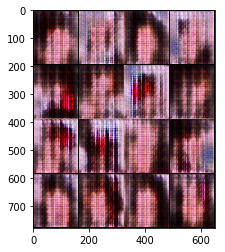

[0/2][550/4053]	Loss_D: 0.7466	Loss_G: 4.0649	D(x): 0.2137	D(G(z)): 0.8864 / 0.9585


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/h

Interrupt


In [0]:
train_gan_s(netD, netG, optimizerD, optimizerDecoder, num_epochs=2)

Starting Training Loop...
[0/5][0/5403]	Loss_D: 0.5536	Loss_G: 10.9616	D(x): 0.2585	D(G(z)): 0.9184 / 0.9335	XE Loss: 3.1078	KLD Loss: 0.3231	MSE Loss: 2.6086
[0/5][100/5403]	Loss_D: 1.1143	Loss_G: 10.0865	D(x): 0.6186	D(G(z)): 0.9846 / 0.7835	XE Loss: 3.7239	KLD Loss: 0.3256	MSE Loss: 2.2584
[0/5][200/5403]	Loss_D: 1.1956	Loss_G: 6.9778	D(x): 0.3699	D(G(z)): 0.7800 / 0.8089	XE Loss: 3.6818	KLD Loss: 0.3261	MSE Loss: 2.2675


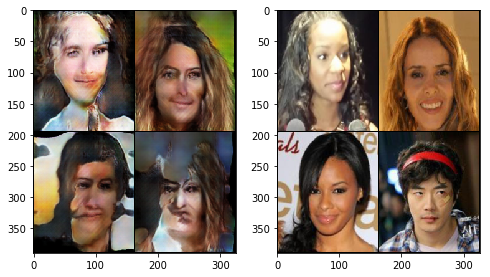

[0/5][300/5403]	Loss_D: 0.9389	Loss_G: 6.5117	D(x): 0.4087	D(G(z)): 0.8168 / 0.8196	XE Loss: 3.6401	KLD Loss: 0.3243	MSE Loss: 2.2575
[0/5][400/5403]	Loss_D: 0.6710	Loss_G: 9.2559	D(x): 0.2640	D(G(z)): 0.8794 / 0.9116	XE Loss: 3.5922	KLD Loss: 0.3213	MSE Loss: 2.2463
[0/5][500/5403]	Loss_D: 0.6973	Loss_G: 11.5695	D(x): 0.2307	D(G(z)): 0.8458 / 0.9662	XE Loss: 3.6165	KLD Loss: 0.3203	MSE Loss: 2.2457


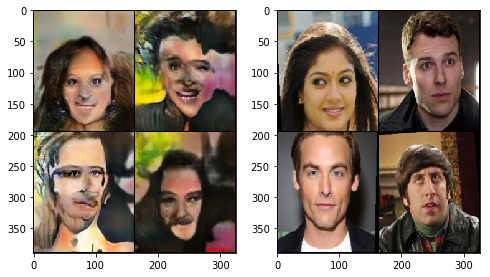

[0/5][600/5403]	Loss_D: 2.0722	Loss_G: 19.4083	D(x): 0.0898	D(G(z)): 0.3529 / 0.9997	XE Loss: 3.6159	KLD Loss: 0.3203	MSE Loss: 2.2477
[0/5][700/5403]	Loss_D: 1.2267	Loss_G: 10.3387	D(x): 0.1616	D(G(z)): 0.5906 / 0.9335	XE Loss: 3.6222	KLD Loss: 0.3193	MSE Loss: 2.2405


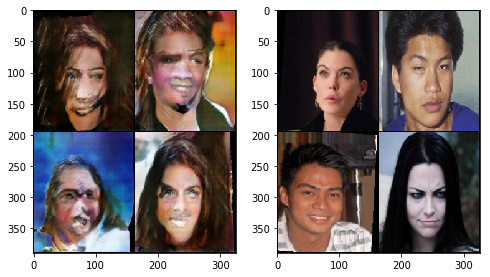

[0/5][800/5403]	Loss_D: 0.6287	Loss_G: 9.4364	D(x): 0.2426	D(G(z)): 0.9012 / 0.9223	XE Loss: 3.6233	KLD Loss: 0.3189	MSE Loss: 2.2360
[0/5][900/5403]	Loss_D: 0.7784	Loss_G: 10.3238	D(x): 0.2932	D(G(z)): 0.9185 / 0.9238	XE Loss: 3.6154	KLD Loss: 0.3188	MSE Loss: 2.2309
[0/5][1000/5403]	Loss_D: 1.0893	Loss_G: 14.3451	D(x): 0.0695	D(G(z)): 0.5794 / 0.9939	XE Loss: 3.6099	KLD Loss: 0.3193	MSE Loss: 2.2266


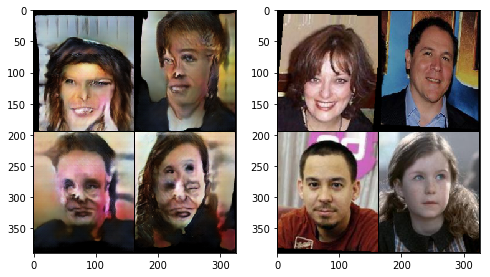

[0/5][1100/5403]	Loss_D: 0.8738	Loss_G: 11.7597	D(x): 0.2745	D(G(z)): 0.9524 / 0.9641	XE Loss: 3.6057	KLD Loss: 0.3188	MSE Loss: 2.2249
[0/5][1200/5403]	Loss_D: 0.8360	Loss_G: 8.8490	D(x): 0.4353	D(G(z)): 0.8650 / 0.7417	XE Loss: 3.6174	KLD Loss: 0.3183	MSE Loss: 2.2224


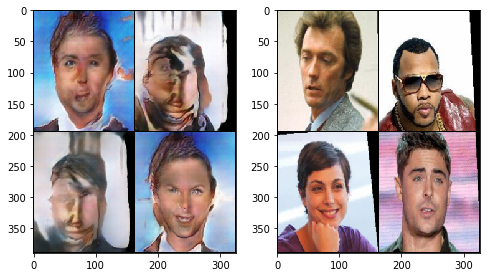

[0/5][1300/5403]	Loss_D: 0.7494	Loss_G: 8.8559	D(x): 0.3256	D(G(z)): 0.9209 / 0.8455	XE Loss: 3.6304	KLD Loss: 0.3181	MSE Loss: 2.2209
[0/5][1400/5403]	Loss_D: 0.7329	Loss_G: 10.7962	D(x): 0.1141	D(G(z)): 0.7717 / 0.9663	XE Loss: 3.6303	KLD Loss: 0.3185	MSE Loss: 2.2192
[0/5][1500/5403]	Loss_D: 1.0703	Loss_G: 16.8331	D(x): 0.0746	D(G(z)): 0.6601 / 0.9960	XE Loss: 3.6409	KLD Loss: 0.3192	MSE Loss: 2.2215


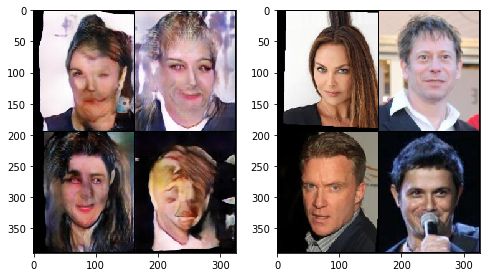

[0/5][1600/5403]	Loss_D: 0.9707	Loss_G: 10.6785	D(x): 0.3576	D(G(z)): 0.9268 / 0.9498	XE Loss: 3.6416	KLD Loss: 0.3195	MSE Loss: 2.2156
[0/5][1700/5403]	Loss_D: 0.6751	Loss_G: 9.5819	D(x): 0.3536	D(G(z)): 0.9244 / 0.9180	XE Loss: 3.6487	KLD Loss: 0.3201	MSE Loss: 2.2159


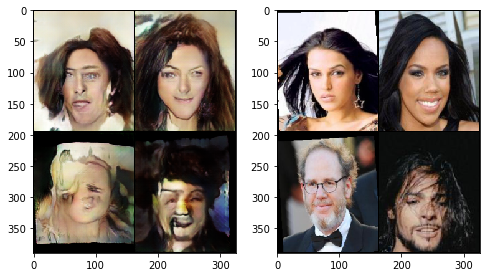

[0/5][1800/5403]	Loss_D: 1.1492	Loss_G: 7.5754	D(x): 0.6168	D(G(z)): 0.9673 / 0.7970	XE Loss: 3.6463	KLD Loss: 0.3204	MSE Loss: 2.2123
[0/5][1900/5403]	Loss_D: 1.0219	Loss_G: 13.5047	D(x): 0.1114	D(G(z)): 0.6714 / 0.9805	XE Loss: 3.6530	KLD Loss: 0.3211	MSE Loss: 2.2092
[0/5][2000/5403]	Loss_D: 0.9928	Loss_G: 7.6533	D(x): 0.5296	D(G(z)): 0.9510 / 0.8669	XE Loss: 3.6559	KLD Loss: 0.3213	MSE Loss: 2.2063


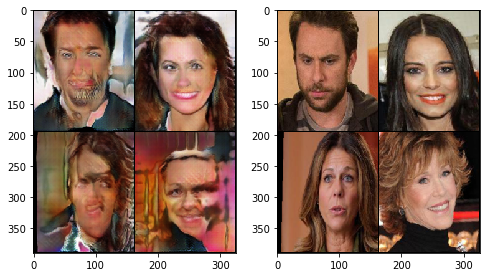

[0/5][2100/5403]	Loss_D: 0.5414	Loss_G: 13.6522	D(x): 0.2575	D(G(z)): 0.9814 / 0.9853	XE Loss: 3.6522	KLD Loss: 0.3215	MSE Loss: 2.2047
[0/5][2200/5403]	Loss_D: 2.0930	Loss_G: 13.1401	D(x): 0.0441	D(G(z)): 0.3129 / 0.9936	XE Loss: 3.6461	KLD Loss: 0.3219	MSE Loss: 2.2024


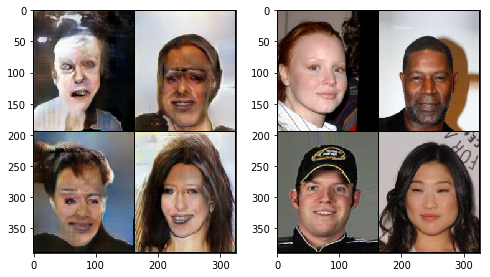

[0/5][2300/5403]	Loss_D: 0.6989	Loss_G: 12.4335	D(x): 0.2486	D(G(z)): 0.8408 / 0.9691	XE Loss: 3.6507	KLD Loss: 0.3224	MSE Loss: 2.1999
[0/5][2400/5403]	Loss_D: 1.4112	Loss_G: 8.0265	D(x): 0.4687	D(G(z)): 0.8507 / 0.8564	XE Loss: 3.6607	KLD Loss: 0.3227	MSE Loss: 2.1992
[0/5][2500/5403]	Loss_D: 1.3875	Loss_G: 5.3397	D(x): 0.6221	D(G(z)): 0.9202 / 0.7085	XE Loss: 3.6581	KLD Loss: 0.3231	MSE Loss: 2.1970


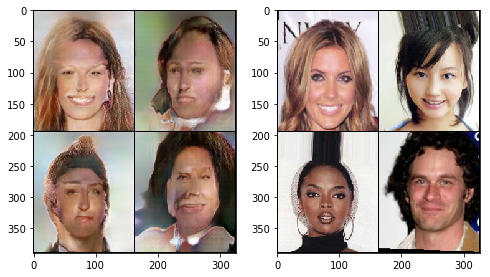

[0/5][2600/5403]	Loss_D: 1.2218	Loss_G: 10.9195	D(x): 0.4207	D(G(z)): 0.9525 / 0.9132	XE Loss: 3.6515	KLD Loss: 0.3233	MSE Loss: 2.1938
[0/5][2700/5403]	Loss_D: 0.8838	Loss_G: 10.7561	D(x): 0.4202	D(G(z)): 0.9890 / 0.8966	XE Loss: 3.6584	KLD Loss: 0.3241	MSE Loss: 2.1925


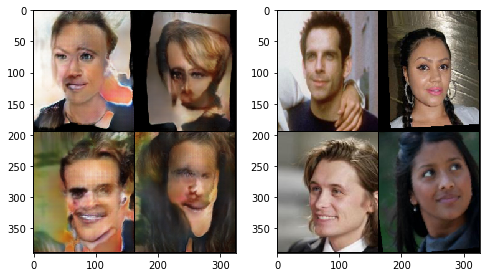

[0/5][2800/5403]	Loss_D: 0.8985	Loss_G: 9.7321	D(x): 0.3391	D(G(z)): 0.8406 / 0.8945	XE Loss: 3.6617	KLD Loss: 0.3249	MSE Loss: 2.1932
[0/5][2900/5403]	Loss_D: 0.8090	Loss_G: 16.4412	D(x): 0.1907	D(G(z)): 0.7624 / 0.9936	XE Loss: 3.6674	KLD Loss: 0.3257	MSE Loss: 2.1926
[0/5][3000/5403]	Loss_D: 0.7270	Loss_G: 10.3023	D(x): 0.1833	D(G(z)): 0.8510 / 0.9501	XE Loss: 3.6699	KLD Loss: 0.3262	MSE Loss: 2.1935


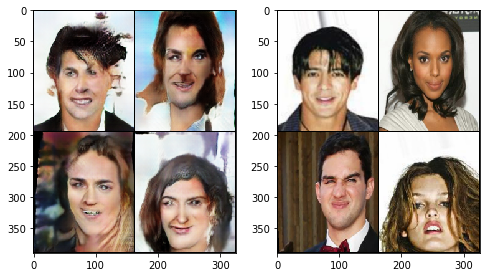

[0/5][3100/5403]	Loss_D: 0.8044	Loss_G: 9.7810	D(x): 0.3948	D(G(z)): 0.9092 / 0.7976	XE Loss: 3.6819	KLD Loss: 0.3269	MSE Loss: 2.1932
[0/5][3200/5403]	Loss_D: 0.6125	Loss_G: 9.4620	D(x): 0.2949	D(G(z)): 0.9371 / 0.8917	XE Loss: 3.6854	KLD Loss: 0.3277	MSE Loss: 2.1938


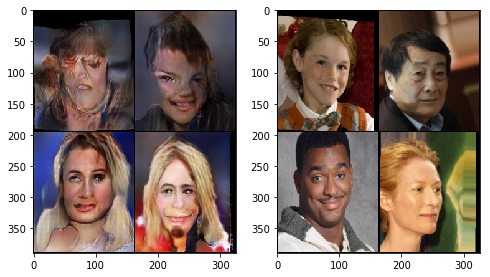

[0/5][3300/5403]	Loss_D: 1.3283	Loss_G: 6.4855	D(x): 0.6269	D(G(z)): 0.9649 / 0.6495	XE Loss: 3.6889	KLD Loss: 0.3283	MSE Loss: 2.1935
[0/5][3400/5403]	Loss_D: 0.5818	Loss_G: 8.5891	D(x): 0.2746	D(G(z)): 0.9177 / 0.8850	XE Loss: 3.6971	KLD Loss: 0.3290	MSE Loss: 2.1932
[0/5][3500/5403]	Loss_D: 0.5062	Loss_G: 9.8937	D(x): 0.1616	D(G(z)): 0.9101 / 0.9198	XE Loss: 3.7066	KLD Loss: 0.3297	MSE Loss: 2.1940


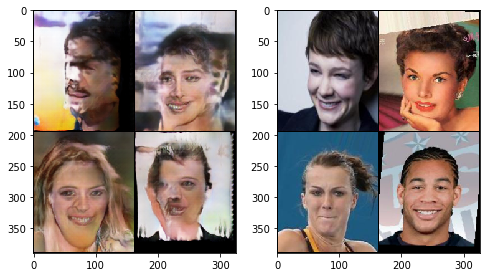

In [0]:
train_gan_3(netD, netG, optimizerD, optimizerG, num_epochs=5)

In [0]:
train_gan_s(netD, netG, optimizerD, optimizerDecoder, num_epochs=5)

In [0]:
train_gan_2(netD, netG, optimizerD, optimizerG, num_epochs=5)

In [0]:
train_gan_4(netD, netG, optimizerD, optimizerG, optimizerDecoder, train_loader=train_loader, num_epochs=5)

In [0]:
train_gan_4(netD, netG, optimizerD, optimizerG, num_epochs=5)

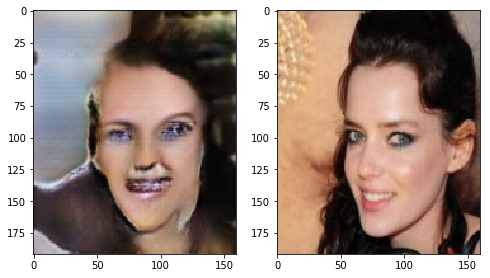

0.3134748339653015
Mean: 0.002449327614158392
Var: 0.46969684958457947
LogVar: -0.5090442895889282
ExpLogVar: 0.6010697530171687


In [0]:
with torch.no_grad():
    for (inputs,_) in test_loader:
        b_size = inputs.shape[0]
        
        inputs = inputs.cuda()
        fake, code, logvar = netG(inputs)
        output = netD(fake).view(-1)
        label = torch.full((b_size,), real_label, device=device)
        errG, MSE_loss, KLD_loss, g_loss = vae_loss(inputs, fake, mu=code, logvar=logvar, d_faked=output, labels=label)
        
        fake = (fake * 0.5) + 0.5
        inputs = (inputs * 0.5) + 0.5
        fig, ax = plt.subplots(2, 2, figsize=(8,8))
        ax[0,0].imshow(fake[0].detach().cpu().permute(1,2,0))
        ax[0,1].imshow(inputs[0].detach().cpu().permute(1,2,0))
        ax[1,0].imshow(fake[1].detach().cpu().permute(1,2,0))
        ax[1,1].imshow(inputs[1].detach().cpu().permute(1,2,0))
        plt.show()
        
        if True: #KLD_loss.item() > 10:
            print(KLD_loss.item())
            print("Mean:", code.mean().item())
            print("Var:", code.var().item())
            print("LogVar:", logvar.mean().item())
            print("ExpLogVar:", np.exp(logvar.mean().item()))
            break

In [0]:
img_list = []
  
# Training Loop
def train_gan_s(netD, netG, optimizerD, optimizerG, num_epochs=5):
    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    iters = 0
    
    try:
        print("Starting Training Loop...")
        # For each epoch
        for epoch in range(num_epochs):
            # For each batch in the dataloader
            for i, data in enumerate(train_loader, 0):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                netD.zero_grad()
                # Format batch
                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, device=device)
                # Forward pass real batch through D
                output = netD(real_cpu).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label + 0.1)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                # Generate fake image batch with G
                fake = netG.decoder(noise)
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = netD(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake
                # Update D
                optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                netG.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = netD(fake).view(-1)
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                # Update G
                optimizerG.step()

                # Output training stats
                if i % 50 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                          % (epoch, num_epochs, i, len(train_loader),
                             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                if i % 100 == 0 and i > 0:
                  with torch.no_grad():
                      fake = netG.decoder(noise).detach().cpu()
                      fake = (fake * 0.5) + 0.5
                      plt.imshow(np.transpose(vutils.make_grid(fake[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
                      plt.show()

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        fake = netG.decoder(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1

            torch.save(netG.state_dict(), g_save_path)
            torch.save(netD.state_dict(), d_save_path)
            
            fake = (fake* 0.5) + 0.5
            # plot some images
            plt.imshow(fake[0].cpu().detach().permute(1,2,0))
            plt.show()
    
    except KeyboardInterrupt:
        print("Interrupt")
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)
    except Exception as e:        
        print("Error", e)
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)

#     !gsutil cp {g_save_path} gs://{bucket_name}/{g_save_path}
#     !gsutil cp {d_save_path} gs://{bucket_name}/{d_save_path}

# Just train the encoder to try to mimic the inputs
def train_encoder(netD, netG, optimizerD, optimizerG, num_epochs=5):
    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    iters = 0
    
    try:
        print("Starting Training Loop...")
        # For each epoch
        for epoch in range(num_epochs):
            # For each batch in the dataloader
            for i, data in enumerate(train_loader, 0):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                netD.zero_grad()
                # Format batch
                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, device=device)
                # Forward pass real batch through D
                output = netD(real_cpu).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label + 0.1)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise, mu, logvar = netG.encoder(real_cpu)
                
                # Generate fake image batch with G
                fake = netG.decoder(noise)
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = netD(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake
                # Update D
                optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                netG.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = netD(fake).view(-1)
                # Calculate G's loss based on this output
                errG = errG, MSE_loss, KLD_loss, g_loss = vae_loss(real_cpu, fake, mu=code, logvar=logvar, d_faked=f_output, labels=label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                # Update G
                optimizerG.step()

                # Output training stats
                if i % 250 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                          % (epoch, num_epochs, i, len(train_loader),
                             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                if i % 500 == 0 and i > 0:
                  with torch.no_grad():
                      fake = netG.decoder(fixed_noise).detach().cpu()
                      fake = (fake * 0.5) + 0.5
                      plt.imshow(np.transpose(vutils.make_grid(fake[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
                      plt.show()

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        fake = netG.decoder(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1

            torch.save(netG.state_dict(), g_save_path)
            torch.save(netD.state_dict(), d_save_path)

            # plot some images
            plt.imshow(fake[0].cpu().detach().permute(1,2,0))
            plt.show()
    
    except KeyboardInterrupt:
        print("Interrupt")
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)
    except Exception as e:        
        print("Error", e)
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)

In [0]:
fixed_noise = torch.randn(16, latent_dim, 1, 1).cuda()
with torch.no_grad():
    fake = netG.decoder(fixed_noise).detach().cpu()
    fake = (fake * 0.5) + 0.5
    plt.imshow(fake[0].detach().cpu().permute(1,2,0))
    plt.show()

In [0]:
if test_loader is not None:
    netD.eval()
    netG.eval()

    r_outputs = []
    f_outputs = []
    g_losses = []
    d_losses = []

    with torch.no_grad():
        for (inputs, _) in test_loader:
            # copy the data to GPU
            inputs = inputs.cuda()
            b_size = inputs.shape[0]
            
            # run the data through the network
            fake, code, logvar = netG(inputs)
            r_output = netD(inputs).view(-1)
            r_outputs.append(r_output)

            f_output = netD(fake).view(-1)
            f_outputs.append(f_output)

            # run the loss functions
            label = torch.full((b_size,), real_label, device=device)
            d_loss_real = criterion(r_output, label)
            d_losses.append(d_loss_real.item())

            label.fill_(fake_label)
            d_loss_fake = criterion(f_output, label)
            d_losses.append(d_loss_fake.item())

            # run the generator loss function
            label.fill_(real_label)
            errG, MSE_loss, KLD_loss, g_loss = vae_loss(inputs, fake, mu=code, logvar=logvar, d_faked=f_output, labels=label)
            g_losses.append(errG.item())

    # print out some images
    plt.imshow(np.transpose(vutils.make_grid(fake.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    plt.show()    
    
    plt.imshow(np.transpose(vutils.make_grid(inputs.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    plt.show()    

In [0]:
torch.save(netG.state_dict(), g_save_path)
torch.save(netD.state_dict(), d_save_path)

In [0]:
train_gan_2(netD, netG, optimizerD, optimizerG, num_epochs=5)

In [0]:
from IPython.display import HTML
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
# check that the discriminator is working properly
with torch.no_grad():
    for (inputs, _) in train_loader:
        netG.eval()
        netD.eval()
        batch_size = inputs.shape[0]
        
        noise = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        recon = netG(inputs)
        
        # feed the original images to the discriminator
        real_probs = torch.sigmoid(netD(inputs.cuda()))
        fake_probs = torch.sigmoid(netD(recon))
        
        probs = torch.cat((real_probs, fake_probs), 0).float()
        labels = torch.cat((torch.zeros(batch_size), torch.ones(batch_size)), 0).cuda()
        
        print("Accuracy:", torch.mean((torch.round(probs) == labels).float()))
        print(fake_probs[0].item())
        plt.imshow(recon[0].cpu().permute(1,2,0))
        plt.title("Recon")
        plt.show()
        
        print(real_probs[0].item())
        plt.imshow(inputs[0].cpu().permute(1,2,0))
        plt.title("Real")
        plt.show()
        
        break

In [0]:
## CHECK MEAN AND VARIANCE OF CODES
with torch.no_grad():
    for (inputs, _) in test_loader:
      generator.encoder.eval()
      generator.decoder.eval()
      # encode the images and reconstruct them
      codes, logvar = generator.encoder(inputs.cuda())
      print("Mean:", torch.mean(codes))
      print("Std:", codes.std())
      recon = generator.decoder(codes)
      d_faked = discriminator(recon)
      print("Faked Logits Mean:", d_faked.mean())
      vae_loss(inputs.cuda(), recon, codes, logvar=logvar, d_faked = d_faked, debug = True)
      break

#### Additional Training on Personal Images

In [0]:
!mkdir data/Train
!cp -r data/images/Training_Pictures data/Train/Images

In [0]:
train_dataset2 = torchvision.datasets.ImageFolder(
        root="data/Train",
        transform=transform
    )

train_loader2 = torch.utils.data.DataLoader(
    train_dataset2,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

In [0]:
# resume training the discriminator as well
train_gan(discriminator, generator, train_loader2, d_optimizer, g_optimizer, print_metrics=1000, plot_images=2000, num_epochs=51, extra_gen_train=1024, test_loader=None, separate_batches=True, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

In [0]:
noise = np.random.normal(loc=0.3, scale=7.5, size=4096).reshape((1,4096,1,1))
image = model.decoder(torch.from_numpy(noise).cuda().float())
plt.imshow(image[0].cpu().detach().permute(1,2,0))
plt.show()